<a href="https://www.kaggle.com/code/awesomeharris/feature-selection-using-rfecv?scriptVersionId=137590089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Introduction**

Recursive Feature Elimination with Cross-Validation (RFECV) is a feature selection technique used in machine learning. It helps determine the optimal set of features for a model by recursively eliminating less important features and selecting the best subset based on cross-validation performance.

I tried RFECV on 3 classifier models:
1. RandomForestClassifier()
2. XGBClassifier
3. LGBMClassifier

Somehow the recommended number of features varies across different models. This seems like something interesting to explore. 

What are your thoughts of this method? 

Reference: [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Import datasets
path1 = "/kaggle/input/icr-identify-age-related-conditions/"
# path1 = ""
df_sample = pd.read_csv(path1+"sample_submission.csv")
df_train = pd.read_csv(path1+"train.csv")
df_test = pd.read_csv(path1+"test.csv")
df_greek = pd.read_csv(path1+"greeks.csv") # additional metadata only available to train dataset

# remove trailing space in some columns
def remove_trailspace_in_col(df):
    df.rename(columns=lambda x: x.strip(), inplace=True)
    return df
remove_trailspace_in_col(df_sample)
remove_trailspace_in_col(df_train)
remove_trailspace_in_col(df_test)
remove_trailspace_in_col(df_greek)

# replace 'Unknown' with default NaN so can parse the column to datetime format
df_greek['Epsilon'].replace('Unknown', np.nan, inplace=True)
df_greek['Epsilon'] = pd.to_datetime(df_greek['Epsilon'])
df_greek['Epsilon'].dtype

# Encode 'EJ' column {'A','B'} to {0, 1}, 
# effectively turning all features to only numerical
first_category = df_train.EJ.unique()[0]
df_train.EJ = df_train.EJ.eq(first_category).astype(int)
df_test.EJ = df_test.EJ.eq(first_category).astype(int)

def CustomSimpleImputer(df, strategy):
    original_columns = df.columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns
    imp_numeric = SimpleImputer(missing_values=np.nan, strategy=strategy)
    df_numeric_imp_array = imp_numeric.fit_transform(df[numeric_columns])
    df_numeric_imp = pd.DataFrame(df_numeric_imp_array, columns=numeric_columns)
    df_combined = pd.concat([df_numeric_imp, df[categorical_columns]], axis=1)    
    df_combined = df_combined[original_columns]
    return df_combined

df_train = CustomSimpleImputer(df_train, 'median')

In [2]:
X = df_train.copy().drop(columns=['Id','Class'])
y = df_train['Class']

def plot_RFECV(classifier):
    min_features_to_select = 1
    clf = classifier
    cv = StratifiedKFold(5)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="neg_log_loss",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
        verbose=0,
    )
    rfecv.fit(X, y)

    print(f"Optimal number of features: {rfecv.n_features_}")
    
    feature_ranking = rfecv.support_
    feature_names = X.columns
    ranking_df = pd.DataFrame({'Feature': feature_names, 'Ranking': feature_ranking})
    ranking_df.sort_values(by='Ranking', ascending=False, inplace=True)
    print(ranking_df)
    
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    return plt.show()

# RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Optimal number of features: 25
   Feature  Ranking
0       AB     True
21      CR     True
26      DE     True
1       AF     True
29      DI     True
30      DL     True
32      DU     True
34      DY     True
35      EB     True
36      EE     True
38      EH     True
44      FD     True
45      FE     True
46      FI     True
47      FL     True
48      FR     True
53      GH     True
25      DA     True
28      DH     True
55      GL     True
16      CC     True
12      BQ     True
5       AX     True
3       AM     True
8       BC     True
50      GB    False
51      GE    False
49      FS    False
52      GF    False
39      EJ    False
2       AH    False
6       AY    False
54      GI    False
7       AZ    False
43      FC    False
42      EU    False
41      EP    False
40      EL    False
4       AR    False
19      CH    False
20      CL    False
9       BD    False
10      BN    False
11      BP    False
33      DV    False
31      DN    False
13      BR    False
14      B

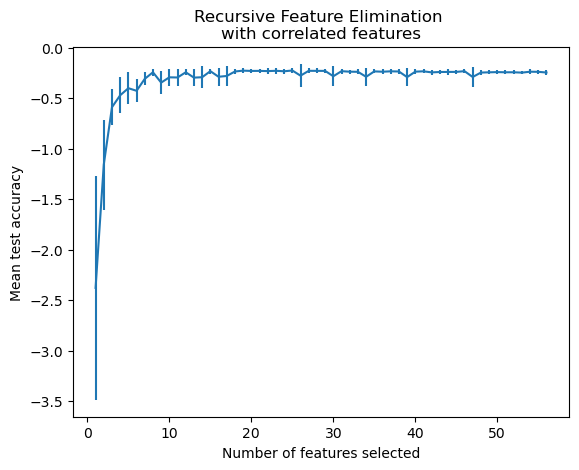

In [3]:
plot_RFECV(RandomForestClassifier())

# XGBClassifier

Optimal number of features: 40
   Feature  Ranking
0       AB     True
25      DA     True
1       AF     True
29      DI     True
30      DL     True
32      DU     True
34      DY     True
35      EB     True
36      EE     True
37      EG     True
38      EH     True
40      EL     True
41      EP     True
42      EU     True
43      FC     True
44      FD     True
45      FE     True
46      FI     True
47      FL     True
48      FR     True
50      GB     True
51      GE     True
53      GH     True
26      DE     True
28      DH     True
13      BR     True
16      CC     True
2       AH     True
6       AY     True
8       BC     True
9       BD     True
10      BN     True
12      BQ     True
23      CU     True
15      CB     True
55      GL     True
17      CD     True
22      CS     True
20      CL     True
21      CR     True
54      GI    False
27      DF    False
52      GF    False
3       AM    False
4       AR    False
49      FS    False
5       AX    False
7       A

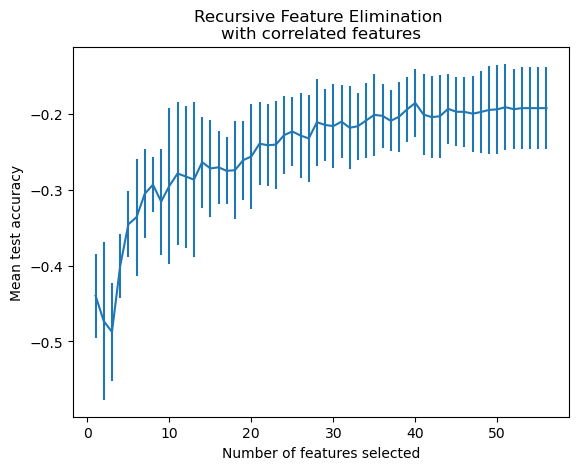

In [4]:
plot_RFECV(XGBClassifier())

# LGBMClassifier

Optimal number of features: 46
   Feature  Ranking
0       AB     True
41      EP     True
29      DI     True
30      DL     True
31      DN     True
32      DU     True
34      DY     True
35      EB     True
36      EE     True
37      EG     True
38      EH     True
40      EL     True
42      EU     True
26      DE     True
43      FC     True
44      FD     True
45      FE     True
46      FI     True
47      FL     True
48      FR     True
49      FS     True
52      GF     True
53      GH     True
54      GI     True
1       AF     True
28      DH     True
25      DA     True
16      CC     True
3       AM     True
5       AX     True
7       AZ     True
8       BC     True
9       BD     True
10      BN     True
11      BP     True
12      BQ     True
15      CB     True
13      BR     True
17      CD     True
19      CH     True
24      CW     True
23      CU     True
21      CR     True
22      CS     True
18      CF     True
55      GL     True
33      DV    False
20      C

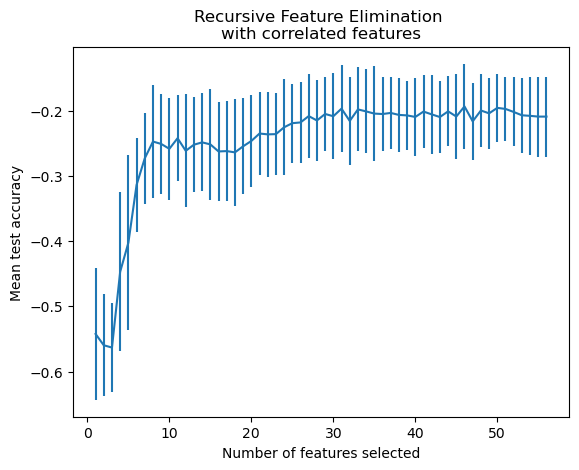

In [5]:
plot_RFECV(LGBMClassifier())